# Neural Networks and Deep Learning

## Data Loading and pre-processing

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn

In [36]:
def load_CIFAR10(batch_size, resize=None):
    """Download the CIFAR10 dataset and then load it into memory."""
    trans = [torchvision.transforms.RandomHorizontalFlip(p=0.5),# Horizontally flip the given image randomly with a given probability.
             torchvision.transforms.RandomRotation(8), #Rotate the image by angle
             torchvision.transforms.ToTensor(),
        ]

    trans = torchvision.transforms.Compose(trans)
    CIFAR10_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=trans, download=True)
    CIFAR10_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=trans, download=True)
    return (torch.utils.data.DataLoader(CIFAR10_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(CIFAR10_test, batch_size, shuffle=False,
                            num_workers=2))

In [37]:
batch_size = 64 # Defines the batch size
train_iter, test_iter = load_CIFAR10(batch_size) # Loads the fashion CIFAR10 dataset. `train_iter` and `test_iter` are `DataLoader` objects.

Files already downloaded and verified
Files already downloaded and verified


In [38]:
X, y = next(iter(train_iter)) # Requests the first training batch
print(X.size()) # Outputs the size of the batch. Each batch contains 64 images (due to batch_size=64). Each image is represented by a 3 x 32 x 32 tensor (number of channels x height x width). The images are in color, so there are three channels.
print(y.size()) # Outputs the size of the targets for the batch. There are 64 targets corresponding to the 64 images, each target is a number between 0 and 9 representing one of the 10 classes in CIFAR10.

torch.Size([64, 3, 32, 32])
torch.Size([64])


## Intermediate Block Generator

In [39]:
class IntermediateBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers):
        super(IntermediateBlock, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.relu = torch.nn.ReLU()
        # # Create a list of convolutional layers to be applied sequentially
        self.conv_layers = torch.nn.ModuleList([torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0) for _ in range(num_conv_layers)])
        self.fc = torch.nn.Linear(in_channels, num_conv_layers) # A fully connected layer to get modulation scalars


    def forward(self, x):
        # Compute the average for each feature map to use as input for the fully connected layer
        m = torch.mean(x, dim=[2, 3])  # Reduces each (B, C, H, W) feature map to (B, C)
        m = self.fc(m) # Generates a scalar for each convolutional layer

        # Compute the outputs of all convolutional layers
        conv_outputs = [self.relu(conv(x)) for conv in self.conv_layers]

        # Modulate the output of each convolutional layer by the corresponding scalar from the fully connected layer
        im_m = []
        for i in range(self.num_conv_layers):
            n = m[:,i]
            n = n.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) # Reshape to (B, 1, 1, 1) for broadcasting
            im_m.append(n * conv_outputs[i]) # Element-wise multiplication

        self.out = sum(im_m) #Sum the modulated outputs from all convolutional layers to form the final output

        return self.out

# The IntermediateBlock_2 and IntermediateBlock_3 classes have a similar structure to IntermediateBlock
# with the primary difference being the input and output channels passed to the Conv2d layers.

class IntermediateBlock_2(torch.nn.Module):
    def __init__(self, out_channels, out_channels_2, num_conv_layers):
        super(IntermediateBlock_2, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.out_channels = out_channels
        self.out_channels_2 = out_channels_2
        self.conv_layers = torch.nn.ModuleList([torch.nn.Conv2d(out_channels, out_channels_2, kernel_size=3, padding=0) for _ in range(num_conv_layers)])
        self.fc = torch.nn.Linear(out_channels, num_conv_layers)
        self.relu = torch.nn.ReLU() # Creates the activation function

    def forward(self, x):
        # Compute the outputs of all convolutional layers
        conv_outputs = [self.relu(conv(x)) for conv in self.conv_layers]

        # Compute the average value for each channel
        m = torch.mean(x, dim=[2, 3]) # Assuming x is of shape (B, C, H, W)
        m = self.fc(m)

        im_m = []
        for i in range(self.num_conv_layers):
            n = m[:,i]
            n = n.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            im_m.append(n * conv_outputs[i])

        self.out = sum(im_m)

        return self.out



class IntermediateBlock_3(torch.nn.Module):
    def __init__(self, out_channels_2, out_channels_3, num_conv_layers):
        super(IntermediateBlock_3, self).__init__()
        self.num_conv_layers = num_conv_layers
        self.out_channels_2 = out_channels_2
        self.out_channels_3 = out_channels_3
        self.conv_layers = torch.nn.ModuleList([torch.nn.Conv2d(out_channels_2, out_channels_3, kernel_size=3, padding=0) for _ in range(num_conv_layers)])
        self.fc = torch.nn.Linear(out_channels_2, num_conv_layers)
        self.relu = torch.nn.ReLU() # Creates the activation function

    def forward(self, x):
        # Compute SSthe outputs of all convolutional layers
        conv_outputs = [self.relu(conv(x)) for conv in self.conv_layers]

        # Compute the average value for each channel
        m = torch.mean(x, dim=[2, 3]) # Assuming x is of shape (B, C, H, W)
        m = self.fc(m)

        im_m = []
        for i in range(self.num_conv_layers):
            n = m[:,i]
            n = n.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            im_m.append(n * conv_outputs[i])

        self.out = sum(im_m)

        return self.out


## Final Model with the output block

In [40]:
class OutputBlock(torch.nn.Module):
    def __init__(self, out_channels_3, num_classes):
        super(OutputBlock, self).__init__()
        self.global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling to reduce each channel to a single value.
        self.fc = torch.nn.Linear(out_channels_3, num_classes)  # Fully Connected Layer for classification.

    def forward(self, x):
        #m = torch.mean(x, dim=[2, 3])
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

In [41]:
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

In [42]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

in_channels = 3 # input channels for the first block
out_channels = 32 # mid-layer channels for IntermediateBlock
out_channels_1 = 64 #add another block here
out_channels_2 = 128
out_channels_3 = 128
num_conv_layers = 3 # Number of conv layers for IntermediateBlock
num_classes = 10  # Number of classes for Output

maxpool = torch.nn.MaxPool2d(2)
dropout = torch.nn.Dropout(0.3)

intermediate_block_instance = IntermediateBlock(in_channels, out_channels, num_conv_layers)
btchnom = torch.nn.BatchNorm2d(out_channels)

intermediate_block_instance_1 = IntermediateBlock(out_channels, out_channels_1, num_conv_layers)
btchnom1 = torch.nn.BatchNorm2d(out_channels_1)

intermediate_block_instance_2 = IntermediateBlock_2(out_channels_1, out_channels_2, num_conv_layers)
btchnom2 = torch.nn.BatchNorm2d(out_channels_2)

intermediate_block_instance_3 = IntermediateBlock_3(out_channels_2, out_channels_3, num_conv_layers)
btchnom3 = torch.nn.BatchNorm2d(out_channels_3)

output_block_instance = OutputBlock(out_channels_3, num_classes)

model = torch.nn.Sequential(
    intermediate_block_instance,
    btchnom,
    intermediate_block_instance_1,
    btchnom1,
    maxpool,
    dropout,
    intermediate_block_instance_2,
    btchnom2,
    intermediate_block_instance_3,
    btchnom3,
    maxpool,
    dropout,
    output_block_instance
).to(device)

def init_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

model.apply(init_weights)  # Applies `init_weights` to every `torch.nn.Module` inside `model`

loss = torch.nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Printing the number of parameters of the model for control and reference
print(f'Total number of parameters: {sum(p.numel() for p in model.parameters())/1e3:.1f}K')


Using cuda.
Total number of parameters: 725.2K


## Training

In [43]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

In [44]:
def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = 0.
    n = 0.
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)

    return float(c / n)

In [45]:
model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
print(f'Training accuracy: {evaluate_metric(model, train_iter, correct)}. Testing accuracy: {evaluate_metric(model, test_iter, correct)}.')

Training accuracy: 0.09999999403953552. Testing accuracy: 0.09999999403953552.



Epoch 1/50.
Training accuracy: 0.36552000045776367. Testing accuracy: 0.36469998955726624.

Epoch 2/50.
Training accuracy: 0.5154399871826172. Testing accuracy: 0.5087000131607056.

Epoch 3/50.
Training accuracy: 0.5728600025177002. Testing accuracy: 0.5598999857902527.

Epoch 4/50.
Training accuracy: 0.6658599972724915. Testing accuracy: 0.6430000066757202.

Epoch 5/50.
Training accuracy: 0.7012799978256226. Testing accuracy: 0.6852999925613403.

Epoch 6/50.
Training accuracy: 0.7307800054550171. Testing accuracy: 0.7091000080108643.

Epoch 7/50.
Training accuracy: 0.7543599605560303. Testing accuracy: 0.7264999747276306.

Epoch 8/50.
Training accuracy: 0.7793999910354614. Testing accuracy: 0.7480999827384949.

Epoch 9/50.
Training accuracy: 0.7953599691390991. Testing accuracy: 0.7568999528884888.

Epoch 10/50.
Training accuracy: 0.809499979019165. Testing accuracy: 0.7630999684333801.

Epoch 11/50.
Training accuracy: 0.8208000063896179. Testing accuracy: 0.7752999663352966.

Epoch 

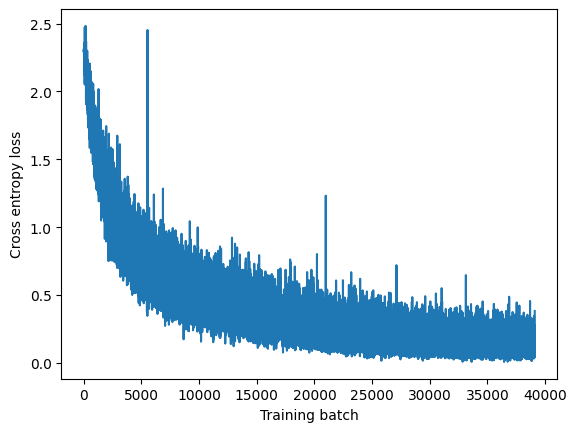

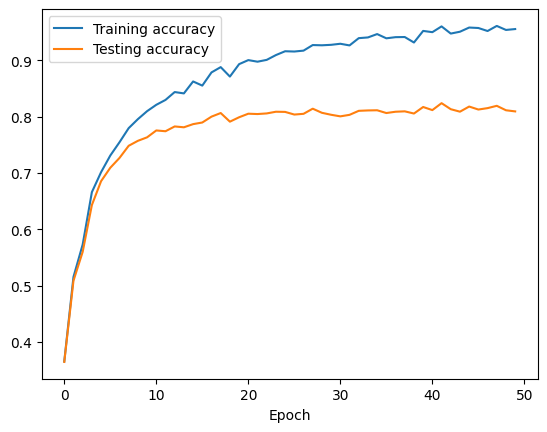

In [46]:
losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

num_epochs = 50
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        logits = model(X) # Computes the logits for the batch of images `X`

        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch

    with torch.no_grad(): # Computing performance metrics does not require gradients
        train_accs.append(evaluate_metric(model, train_iter, correct))
        test_accs.append(evaluate_metric(model, test_iter, correct))
        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.

plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()